# Truck Freight Price Prediction

All the data is inside the [data/](data/) folder.

The goal of this exercise is to use all the data available to create a model that predicts the price of moving a shipment (also known as load) in a price range that will be acceptable by carriers in the USA freight market.

You are allowed to create new features based on the given data, or even fetching additional external data.
Nevertheless, the latter will be more difficult and harder to validate.
Just with the data made available to you, it should be possible to create a valid and useful model.

One important thing, be careful to **never use future information**. 
The model won't have access to information in the future, so that would be "cheating".
You can use the `quote_date` column inside the `base_data` dataset to see when the Shipment happened.

Please follow this notebook on how to predict and validate the results.

When validating the results, it's recommended to use the function provided.
Feel free to use other forms of validation, but the provided function will help us compare your results with ours.

```python
from utils import time_series_validation

results = time_series_validation(X, y, base_data=base_data, model=model)
```

## Processed data

In [data/processed/](data/processed/) folder, we have made available:

- `X.parquet`: feature dataset
- `y.parquet`: target variable
- `base_data.parquet`: dataset containing some basic information of the shipments, such as the date the shipment was quoted.

All datasets have the same row ordering, so they can be loaded using pandas and directly joined using the DataFrame's index.

Each row is an individual shipment that was moved with a given source price.
Source price is the effective price given and accepted by a carrier.


In [ ]:
# requirements used by our own model
#!pip3 install scikit-learn==1.0.2 pandas==1.4.2 pyarrow==8.0.0

In [ ]:
!pip install --user pyarrow
!pip install --user geopandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 31.4 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Loading the data

### Load

In [ ]:

%load_ext autoreload
%autoreload 2

In [ ]:
#manage paths 
from google.colab import drive
drive.mount('/content/gdrive')
alexa_path = '/content/gdrive/MyDrive/SCM.C51/SCM.C51 Loadsmart Project/' #Please insert file path here before running

Mounted at /content/gdrive


In [ ]:
from os.path import join
import pandas as pd

# needs pyarrow package installed
X = pd.read_parquet(join(alexa_path,"data", "processed", "X.parquet"))
y = pd.read_parquet(join(alexa_path,"data", "processed", "y.parquet"))
base_data = pd.read_parquet(join(alexa_path,"data", "processed", "base_data.parquet"))
us_gdp = pd.read_csv(join(alexa_path, "data", "processed", "us-monthly-gdp.csv"))

In [ ]:
base_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251389 entries, 0 to 251388
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   equipment_type       251389 non-null  object             
 1   commodity            235651 non-null  object             
 2   origin_latitude      251389 non-null  float64            
 3   origin_longitude     251389 non-null  float64            
 4   origin_city          251389 non-null  object             
 5   origin_state         251389 non-null  object             
 6   origin_zipcode       251389 non-null  object             
 7   origin_country       251389 non-null  object             
 8   dest_latitude        251389 non-null  float64            
 9   dest_longitude       251389 non-null  float64            
 10  dest_city            251389 non-null  object             
 11  dest_state           251389 non-null  object             
 12  de

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251389 entries, 0 to 251388
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   equipment_type          251389 non-null  category
 1   origin_latitude         251389 non-null  float64 
 2   origin_longitude        251389 non-null  float64 
 3   dest_latitude           251389 non-null  float64 
 4   dest_longitude          251389 non-null  float64 
 5   matched_carriers_count  251389 non-null  int64   
 6   last_30_days            251389 non-null  float64 
 7   origin_hq_count         251389 non-null  float64 
 8   dest_hq_count           251389 non-null  float64 
 9   origin_kma              251389 non-null  category
 10  dest_kma                251389 non-null  category
 11  urbanicity              251389 non-null  float64 
 12  hour_of_day             251389 non-null  int64   
 13  effective_hours         251389 non-null  float64 
 14  lead

In [ ]:
X.head(5)

,equipment_type,origin_latitude,origin_longitude,dest_latitude,dest_longitude,matched_carriers_count,last_30_days,origin_hq_count,dest_hq_count,origin_kma,dest_kma,urbanicity,hour_of_day,effective_hours,lead_time_hours,weight,direct_mileage,drop_trailer,rolling,team_driver
0,R,41.50,-87.31,34.04,-117.36,903,11.0,139.0,497.0,IN_GRY,CA_ONT,23.480618,2,81.093333,85.033333,30113,1997.4,0,False,False
1,V,39.10,-84.51,40.75,-84.07,5900,43.0,1899.0,147.0,OH_CIN,OH_TOL,73.679459,8,9.950000,18.100000,45000,122.6,0,False,False
2,V,40.62,-105.01,38.75,-90.14,2606,1620.0,550.0,128.0,CO_DEN,MO_STL,69.816433,20,95.560000,86.800000,45000,887.0,0,False,False
3,V,47.23,-122.24,34.02,-117.55,2774,41.0,138.0,100.0,WA_SEA,CA_ONT,32.860061,11,110.800000,103.000000,20000,1153.5,0,False,False
4,V,34.20,-118.50,37.66,-120.88,4327,2321.0,15108.0,1506.0,CA_LAX,CA_STK,48.320168,18,105.591667,103.316667,45000,295.6,0,False,False


In [ ]:
base_data.head()

,equipment_type,commodity,origin_latitude,origin_longitude,origin_city,origin_state,origin_zipcode,origin_country,dest_latitude,dest_longitude,...,dest_state,dest_zipcode,dest_country,pickup_date,direct_mileage,quote_date,weight,origin_drop_trailer,dest_drop_trailer,team_driver
0,R,Bakery Products,41.499000,-87.310000,hobart,in,46342,USA,34.039000,-117.361000,...,ca,92324,USA,2019-04-11 07:00:00+00:00,1997.4,2019-04-05 17:58:32.112000+00:00,30113,False,False,False
1,V,Dry Goods,39.103118,-84.512020,cincinnati,oh,45202,USA,40.745335,-84.066520,...,oh,45804,USA,2020-06-15 12:00:00+00:00,122.6,2020-06-12 17:54:26.392000+00:00,45000,False,False,False
2,V,BEER - WILL LOAD TRUCK TO MAX GROSS WEIGHT,40.617477,-105.005116,fort collins,co,80524,USA,38.745130,-90.136879,...,il,62040,USA,2020-04-24 02:00:00+00:00,887.0,2020-04-20 11:12:39.830000+00:00,45000,False,False,False
3,V,Coffee,47.226000,-122.242000,sumner,wa,98390,USA,34.023000,-117.547000,...,ca,91752,USA,2019-05-03 18:00:00+00:00,1153.5,2019-04-29 11:00:26.697000+00:00,20000,False,False,False
4,V,BEER - WILL LOAD TRUCK TO MAX GROSS WEIGHT,34.198512,-118.498074,los angeles,ca,91406,USA,37.664462,-120.884343,...,ca,95357,USA,2020-01-24 02:00:00+00:00,295.6,2020-01-17 18:41:49.245000+00:00,45000,False,False,False


In [ ]:
X.describe()

,origin_latitude,origin_longitude,dest_latitude,dest_longitude,matched_carriers_count,last_30_days,origin_hq_count,dest_hq_count,urbanicity,hour_of_day,effective_hours,lead_time_hours,weight,direct_mileage,drop_trailer
count,251389.000000,251389.000000,251389.000000,251389.000000,251389.000000,251389.000000,251389.000000,251389.000000,251389.000000,251389.000000,251389.000000,251389.000000,2.513890e+05,251389.000000,251389.000000
mean,37.689514,-90.149432,37.430881,-90.913140,3860.914933,83.575729,971.532056,972.157724,61.430394,12.416068,106.805027,104.398709,3.477734e+04,606.566384,0.069924
std,4.330873,13.266910,4.696900,13.753419,1506.691022,582.546288,2023.980478,1889.954211,44.173313,4.141366,89.070844,86.364101,3.083866e+04,542.800002,0.255019
min,25.530000,-124.280000,25.430000,-124.200000,323.000000,0.000000,0.000000,0.000000,0.292434,0.000000,0.000000,0.000000,1.000000e+00,15.100000,0.000000
25%,34.200000,-95.820000,33.770000,-97.030000,2875.000000,1.000000,91.000000,89.000000,29.443853,9.000000,53.226667,51.083333,2.500000e+04,234.200000,0.000000
50%,38.730000,-86.070000,38.480000,-87.020000,4076.000000,7.000000,239.000000,246.000000,52.525224,13.000000,89.193333,87.366667,4.200000e+04,433.300000,0.000000
75%,40.750000,-80.950000,41.090000,-81.300000,4860.000000,33.000000,838.000000,841.000000,80.023728,15.000000,134.830000,129.283333,4.477500e+04,786.900000,0.000000
max,48.990000,-67.830000,49.170000,-67.300000,6688.000000,103923.000000,15108.000000,15108.000000,440.894762,23.000000,6407.675000,6258.500000,4.960637e+06,3301.300000,1.000000


In [ ]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251389 entries, 0 to 251388
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   source_price  251389 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [ ]:
y.head(5)

,source_price
0,3000.0
1,450.0
2,821.0
3,1300.0
4,815.0


In [ ]:
y.describe()

,source_price
count,251389.000000
mean,1783.102729
std,1274.138933
min,301.000000
25%,900.000000
50%,1356.000000
75%,2300.000000
max,10000.000000


In [ ]:
us_gdp.head()

,year_month,year,month,nominal_gdp_index,real_gdp_index,Unnamed: 5,Unnamed: 6
0,2015 - Jan,2015.0,1.0,17927.08,17274.73,NaN,NaN
1,2015 - Feb,2015.0,2.0,18058.52,17353.58,NaN,NaN
2,2015 - Mar,2015.0,3.0,17988.45,17213.76,NaN,NaN
3,2015 - Apr,2015.0,4.0,18148.70,17389.55,NaN,NaN
4,2015 - May,2015.0,5.0,18179.29,17349.78,NaN,NaN


In [ ]:
us_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year_month         98 non-null     object 
 1   year               98 non-null     float64
 2   month              98 non-null     float64
 3   nominal_gdp_index  98 non-null     float64
 4   real_gdp_index     98 non-null     float64
 5   Unnamed: 5         0 non-null      float64
 6   Unnamed: 6         0 non-null      float64
dtypes: float64(6), object(1)
memory usage: 6.6+ KB


In [ ]:
us_gdp.describe()

,year,month,nominal_gdp_index,real_gdp_index,Unnamed: 5,Unnamed: 6
count,98.000000,98.000000,98.000000,98.000000,0.0,0.0
mean,2018.591837,6.397959,21126.881735,18649.535612,NaN,NaN
std,2.367463,3.507693,2436.365546,933.758144,NaN,NaN
min,2015.000000,1.000000,17927.080000,16575.000000,NaN,NaN
25%,2017.000000,3.000000,19067.772500,17837.190000,NaN,NaN
50%,2019.000000,6.000000,20803.435000,18707.175000,NaN,NaN
75%,2021.000000,9.000000,22169.672500,19344.820000,NaN,NaN
max,2023.000000,12.000000,26437.760000,20283.660000,NaN,NaN


In [ ]:
us_gdp = us_gdp.drop(columns = ['Unnamed: 5', 'Unnamed: 6'])

### Data Visualizations

#### Price

Text(0.5, 1.0, 'Distribution of Source Price')

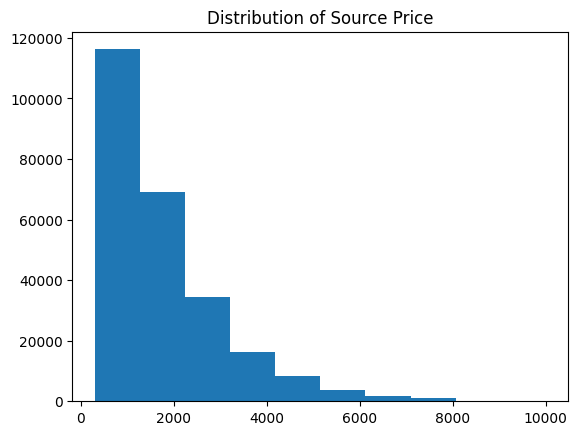

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y)
plt.title("Distribution of Source Price")

Text(0.5, 1.0, 'Distribution of Log Source Price')

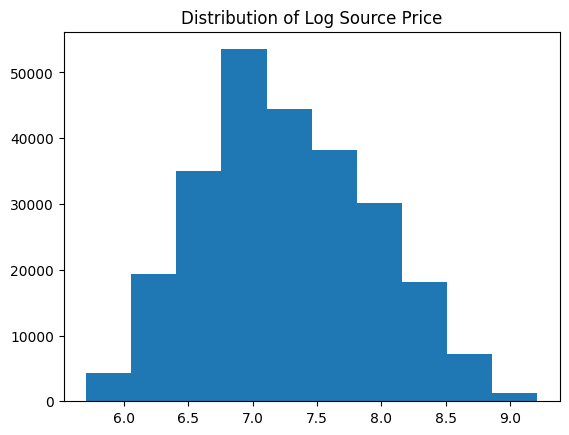

In [ ]:
plt.hist(np.log(y))
plt.title("Distribution of Log Source Price")

#### Input Variables from X


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251389 entries, 0 to 251388
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   equipment_type          251389 non-null  category
 1   origin_latitude         251389 non-null  float64 
 2   origin_longitude        251389 non-null  float64 
 3   dest_latitude           251389 non-null  float64 
 4   dest_longitude          251389 non-null  float64 
 5   matched_carriers_count  251389 non-null  int64   
 6   last_30_days            251389 non-null  float64 
 7   origin_hq_count         251389 non-null  float64 
 8   dest_hq_count           251389 non-null  float64 
 9   origin_kma              251389 non-null  category
 10  dest_kma                251389 non-null  category
 11  urbanicity              251389 non-null  float64 
 12  hour_of_day             251389 non-null  int64   
 13  effective_hours         251389 non-null  float64 
 14  lead

In [ ]:
X['equipment_type'].unique()

['R', 'V', 'F']
Categories (3, object): ['V', 'R', 'F']

Text(0.5, 1.0, 'Equipment Type Counts')

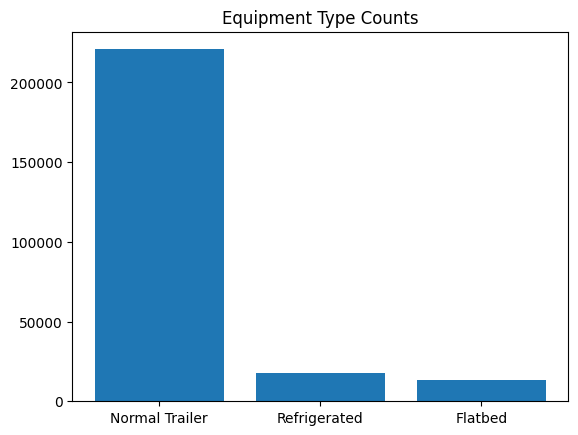

In [ ]:
#be dry van (normal trailer), reefer (refrigerated), or flatbed (no trailer, only the bed of the truck)
V = len(X[X['equipment_type']=='V'])
R = len(X[X['equipment_type']=='R'])
F = len(X[X['equipment_type']=='F'])
equipment_type_dict = {'Normal Trailer': V, 'Refrigerated': R, 'Flatbed':F}
plt.bar(equipment_type_dict.keys(), equipment_type_dict.values())
plt.title("Equipment Type Counts")

##### Location / Path Variables

In [ ]:
origin_location_str = list(zip(X['origin_latitude'],X['origin_longitude']))
dest_loc_str = list(zip(X['dest_latitude'],X['dest_longitude']))
origin_unique = list(set(origin_location_str))
dest_unique = list(set(dest_loc_str))
#origin_location_str
dest_unique

[(27.39, -82.45),
 (41.09, -85.18),
 (32.65, -97.34),
 (39.46, -84.48),
 (40.28, -75.3),
 (42.12, -75.98),
 (40.36, -74.47),
 (36.19, -83.36),
 (32.91, -80.67),
 (29.68, -95.55),
 (40.97, -81.47),
 (29.54, -98.44),
 (36.35, -85.33),
 (45.41, -122.54),
 (40.08, -82.38),
 (41.67, -87.74),
 (26.22, -98.18),
 (32.5, -92.15),
 (39.72, -105.23),
 (42.36, -71.05),
 (31.82, -106.4),
 (39.23, -84.45),
 (42.13, -72.76),
 (44.93, -93.4),
 (39.45, -84.36),
 (30.84, -83.98),
 (32.64, -97.22),
 (36.09, -79.93),
 (35.83, -90.72),
 (28.08, -81.9),
 (40.72, -73.42),
 (35.23, -81.32),
 (35.93, -86.54),
 (44.9, -123.08),
 (32.83, -97.35),
 (36.04, -86.63),
 (34.23, -88.68),
 (40.72, -73.92),
 (40.91, -73.05),
 (39.14, -77.2),
 (34.01, -118.23),
 (36.52, -86.03),
 (42.03, -90.66),
 (43.03, -76.47),
 (35.96, -78.54),
 (44.64, -93.23),
 (32.37, -96.9),
 (39.63, -75.95),
 (33.68, -84.05),
 (40.0, -74.86),
 (44.16, -94.0),
 (33.84, -86.27),
 (28.42, -81.5),
 (40.73, -85.2),
 (40.59, -75.72),
 (41.45, -88.12),

In [ ]:
# origin_unique.count((40.69, -74.0)) testing output

In [ ]:
origin_loc_dic = {}
for p in origin_unique:
  origin_loc_dic[p] = origin_location_str.count(p)

#plt.bar(origin_loc_dic.keys(), origin_loc_dic.values())
#plt.title('Count of Unique Origins')

origin_loc_dic

KeyboardInterrupt: ignored

In [ ]:
dest_loc_dic = {}
for p in dest_unique:
  dest_loc_dic[p] = dest_loc_str.count(p)


#plt.bar(dest_loc_dic.keys(), dest_loc_dic.values())
#plt.title('Count of Unique Destinations')

In [ ]:
#paths = list(zip(X['origin_latitude'],X['origin_longitude'],X['dest_latitude'],X['dest_longitude']))
paths = list(zip(origin_unique, dest_unique))
paths

In [ ]:
import plotly.express as px

fig = px.scatter_geo(X,lat='origin_latitude',lon='origin_longitude')
fig.update_layout(title = 'Origin Locations', title_x=0.5)
fig.show()

In [ ]:
fig = px.scatter_geo(X,lat='dest_latitude',lon='dest_longitude')
fig.update_layout(title = 'Destination Locations', title_x=0.5)
fig.show()

##### Path Characteristics

In [ ]:
plt.hist(X['matched_carriers_count'])
plt.title('Number of carriers that can move the load in a given lane')

In [ ]:
plt.hist(X['last_30_days'])
plt.title('# of quotes in the past 30 days for same path')

In [ ]:
X['last_30_days'].describe()

In [ ]:
plt.hist(X['origin_hq_count'])

In [ ]:
X['origin_hq_count'].describe()

In [ ]:

plt.hist(X['dest_hq_count'])

In [ ]:
X['dest_hq_count'].describe()

In [ ]:
 X['urbanicity'].describe()

In [ ]:
plt.hist(X['urbanicity'])
plt.title('How Close the Load is to the Center of a Key Market Area')

##### Time Characteristics

Text(0.5, 1.0, 'Hour of Day of Pickup Time')

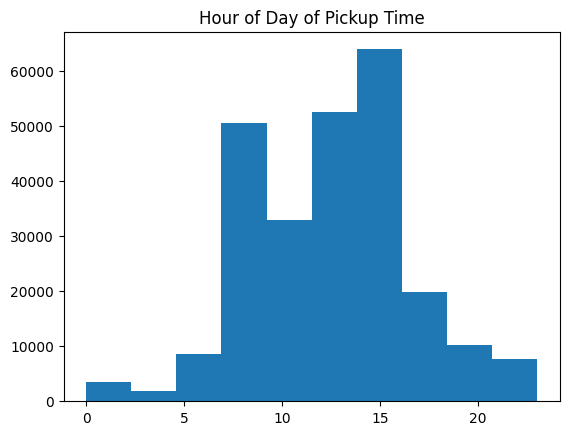

In [ ]:
plt.hist(X['hour_of_day'])
plt.title('Hour of Day of Pickup Time')

(array([2.50735e+05, 6.04000e+02, 4.80000e+01, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([   0.    ,  640.7675, 1281.535 , 1922.3025, 2563.07  , 3203.8375,
        3844.605 , 4485.3725, 5126.14  , 5766.9075, 6407.675 ]),
 <BarContainer object of 10 artists>)

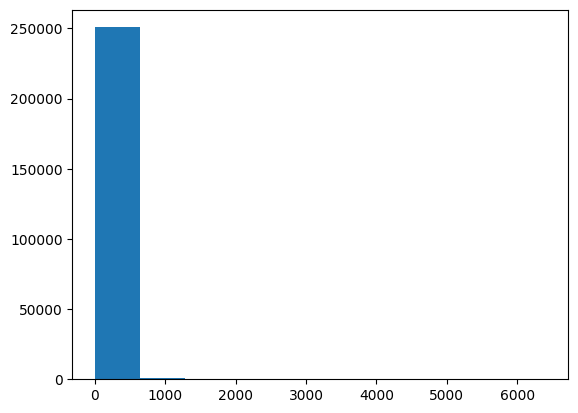

In [ ]:
plt.hist(X['effective_hours'])

In [ ]:
X['effective_hours'].describe()

count    251389.000000
mean        106.805027
std          89.070844
min           0.000000
25%          53.226667
50%          89.193333
75%         134.830000
max        6407.675000
Name: effective_hours, dtype: float64

Text(0.5, 1.0, 'Total number of hours from quote to pickup.')

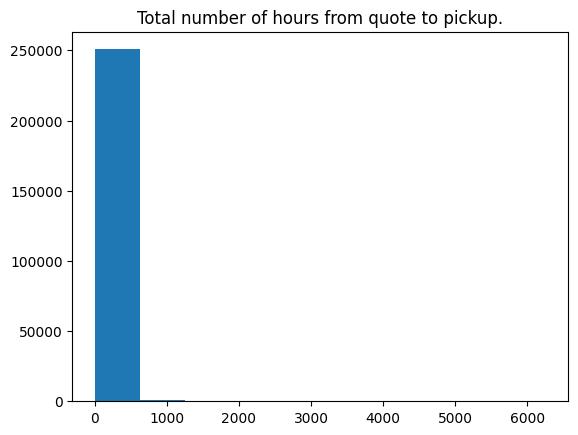

In [ ]:
plt.hist(X['lead_time_hours'])
plt.title('Total number of hours from quote to pickup.')

In [ ]:
X['lead_time_hours'].describe()

count    251389.000000
mean        104.398709
std          86.364101
min           0.000000
25%          51.083333
50%          87.366667
75%         129.283333
max        6258.500000
Name: lead_time_hours, dtype: float64

##### Load Characteristics

In [ ]:
plt.hist(X['weight'])
plt.title('Weight of the shipment`s load')

In [ ]:
X['weight'].describe()

In [ ]:
plt.hist(X['direct_mileage'])
plt.title('Mileage from origin to destination')

In [ ]:
#plt.hist(X['fuel_rate']) missing

In [ ]:
zero = len(X[X['drop_trailer']==0])
one = len(X[X['drop_trailer']==1])
drop_trailer_dict = {'False': zero, 'True': one}
plt.bar(drop_trailer_dict.keys(), drop_trailer_dict.values())
plt.title('If the trailer needs to be dropped at either the origin or the destination') #investigate the one - what does this mean

In [ ]:
F = len(X[X['rolling']==False])
T = len(X[X['rolling']==True])
rolling_dict = {'False': F, 'True': T}
plt.bar(rolling_dict.keys(), rolling_dict.values())
plt.title('If the load`s original pickup date was rolled to a future date') #investigate the True

In [ ]:
F = len(X[X['team_driver']==False])
T = len(X[X['team_driver']==True])
team_driver_dict = {'False': F, 'True': T}
plt.bar(team_driver_dict.keys(), team_driver_dict.values())
plt.title('If the shipment requires a team driver (otherwise, could be a single driver)') #investigate the False

#### Base Data Variables

In [ ]:
import copy
X1 = copy.deepcopy(base_data)

In [ ]:
good_unique = X1['commodity'].unique()
commodity_dic = {}
for good in good_unique:
    commodity_dic[good] = len(X1[X1['commodity']==good])
plt.bar(commodity_dic.keys(), commodity_dic.values())
plt.title("Commodity Type Counts")


In [ ]:
X1['commodity'].describe()

In [ ]:
commodity_dic

In [ ]:
plt.hist(X1['pickup_date'])
plt.title('Date of pickup of the load')

In [ ]:
plt.hist(X1['quote_date'])
plt.title('Day of Quote')

In [ ]:
zero = len(X1[X1['origin_drop_trailer']==0])
one = len(X1[X1['origin_drop_trailer']==1])
orig_drop_trailer_dict = {'False': zero, 'True': one}
plt.bar(orig_drop_trailer_dict.keys(), orig_drop_trailer_dict.values())
plt.title('If the trailer needs to be dropped at the origin') #investigate the one - what does this mean

In [ ]:
zero = len(X1[X1['dest_drop_trailer']==0])
one = len(X1[X1['dest_drop_trailer']==1])
dest_drop_trailer_dict = {'False': zero, 'True': one}
plt.bar(dest_drop_trailer_dict.keys(), dest_drop_trailer_dict.values())
plt.title('If the trailer needs to be dropped at the destination') #investigate the one - what does this mean

##### Location Variables

In [ ]:
good_unique = X1['commodity'].unique()
commodity_dic = {}
for good in good_unique:
  commodity_dic[good] = len(X1[X1['commodity']==good])
plt.bar(commodity_dic.keys(), commodity_dic.values())
plt.title("Commodity Type Counts")

In [ ]:
X1['origin_country'].unique()

In [ ]:
X1['dest_country'].unique()

In [ ]:
X1['origin_state'].unique() #49

In [ ]:
X1['dest_state'].unique()

In [ ]:
X1['origin_city'].unique()

In [ ]:
X1['dest_city'].unique()

## Building a model pipeline

When working with real world data, it's good practice to create a Pipeline for the model.

Sklearn also requires the data to be numeric and without empty values.

### Our code

#### Making combined dataset

In [ ]:
base_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251389 entries, 0 to 251388
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   equipment_type       251389 non-null  object             
 1   commodity            235651 non-null  object             
 2   origin_latitude      251389 non-null  float64            
 3   origin_longitude     251389 non-null  float64            
 4   origin_city          251389 non-null  object             
 5   origin_state         251389 non-null  object             
 6   origin_zipcode       251389 non-null  object             
 7   origin_country       251389 non-null  object             
 8   dest_latitude        251389 non-null  float64            
 9   dest_longitude       251389 non-null  float64            
 10  dest_city            251389 non-null  object             
 11  dest_state           251389 non-null  object             
 12  de

In [ ]:
#drop repeated columns from X
base_data1 = base_data.drop(base_data.columns[[0, 20, 2, 3, 8, 9, 15, 17]],axis=1)

In [ ]:
#combine X and base_data
big_df = pd.concat([X, base_data1], axis=1)
big_df.head(5)

,equipment_type,origin_latitude,origin_longitude,dest_latitude,dest_longitude,matched_carriers_count,last_30_days,origin_hq_count,dest_hq_count,origin_kma,...,origin_zipcode,origin_country,dest_city,dest_state,dest_zipcode,dest_country,pickup_date,quote_date,origin_drop_trailer,dest_drop_trailer
0,R,41.50,-87.31,34.04,-117.36,903,11.0,139.0,497.0,IN_GRY,...,46342,USA,colton,ca,92324,USA,2019-04-11 07:00:00+00:00,2019-04-05 17:58:32.112000+00:00,False,False
1,V,39.10,-84.51,40.75,-84.07,5900,43.0,1899.0,147.0,OH_CIN,...,45202,USA,lima,oh,45804,USA,2020-06-15 12:00:00+00:00,2020-06-12 17:54:26.392000+00:00,False,False
2,V,40.62,-105.01,38.75,-90.14,2606,1620.0,550.0,128.0,CO_DEN,...,80524,USA,granite city,il,62040,USA,2020-04-24 02:00:00+00:00,2020-04-20 11:12:39.830000+00:00,False,False
3,V,47.23,-122.24,34.02,-117.55,2774,41.0,138.0,100.0,WA_SEA,...,98390,USA,jurupa valley,ca,91752,USA,2019-05-03 18:00:00+00:00,2019-04-29 11:00:26.697000+00:00,False,False
4,V,34.20,-118.50,37.66,-120.88,4327,2321.0,15108.0,1506.0,CA_LAX,...,91406,USA,modesto,ca,95357,USA,2020-01-24 02:00:00+00:00,2020-01-17 18:41:49.245000+00:00,False,False


In [ ]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251389 entries, 0 to 251388
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   equipment_type          251389 non-null  category           
 1   origin_latitude         251389 non-null  float64            
 2   origin_longitude        251389 non-null  float64            
 3   dest_latitude           251389 non-null  float64            
 4   dest_longitude          251389 non-null  float64            
 5   matched_carriers_count  251389 non-null  int64              
 6   last_30_days            251389 non-null  float64            
 7   origin_hq_count         251389 non-null  float64            
 8   dest_hq_count           251389 non-null  float64            
 9   origin_kma              251389 non-null  category           
 10  dest_kma                251389 non-null  category           
 11  urbanicity              25

In [ ]:
#creating unique id for each datapoint
big_df['id'] = big_df.index
big_df

,equipment_type,origin_latitude,origin_longitude,dest_latitude,dest_longitude,matched_carriers_count,last_30_days,origin_hq_count,dest_hq_count,origin_kma,...,origin_country,dest_city,dest_state,dest_zipcode,dest_country,pickup_date,quote_date,origin_drop_trailer,dest_drop_trailer,id
0,R,41.50,-87.31,34.04,-117.36,903,11.0,139.0,497.0,IN_GRY,...,USA,colton,ca,92324,USA,2019-04-11 07:00:00+00:00,2019-04-05 17:58:32.112000+00:00,False,False,0
1,V,39.10,-84.51,40.75,-84.07,5900,43.0,1899.0,147.0,OH_CIN,...,USA,lima,oh,45804,USA,2020-06-15 12:00:00+00:00,2020-06-12 17:54:26.392000+00:00,False,False,1
2,V,40.62,-105.01,38.75,-90.14,2606,1620.0,550.0,128.0,CO_DEN,...,USA,granite city,il,62040,USA,2020-04-24 02:00:00+00:00,2020-04-20 11:12:39.830000+00:00,False,False,2
3,V,47.23,-122.24,34.02,-117.55,2774,41.0,138.0,100.0,WA_SEA,...,USA,jurupa valley,ca,91752,USA,2019-05-03 18:00:00+00:00,2019-04-29 11:00:26.697000+00:00,False,False,3
4,V,34.20,-118.50,37.66,-120.88,4327,2321.0,15108.0,1506.0,CA_LAX,...,USA,modesto,ca,95357,USA,2020-01-24 02:00:00+00:00,2020-01-17 18:41:49.245000+00:00,False,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251384,V,30.54,-91.13,30.17,-94.18,5084,46.0,838.0,510.0,LA_NEW,...,USA,beaumont,tx,77708,USA,2022-08-08 18:00:00+00:00,2022-08-05 15:03:10.250000+00:00,False,False,251384
251385,F,31.11,-83.42,27.77,-82.39,926,0.0,103.0,44.0,GA_TIF,...,USA,apollo beach,fl,33572,USA,2022-08-18 11:00:00+00:00,2022-08-04 12:22:42.311000+00:00,False,False,251385
251386,V,34.05,-117.46,32.96,-96.91,2814,0.0,3181.0,422.0,CA_ONT,...,USA,carrollton,tx,75006,USA,2022-08-12 21:00:00+00:00,2022-08-09 15:00:33.177000+00:00,False,False,251386
251387,V,37.73,-121.52,37.91,-121.25,4327,5.0,881.0,2457.0,CA_STK,...,USA,stockton,ca,95206,USA,2022-08-15 18:00:00+00:00,2022-08-10 14:25:04.723000+00:00,False,False,251387


#### making distance

In [ ]:
#!pip install haversine
#from haversine import haversine, Unit
#from shapely.geometry import Point
from geopy.point import Point
#from geopy.distance import geodesic
from geopy.distance import distance

#!pip install mpu --user
#import mpu

In [ ]:
big_df['origin_coord'] = [Point(xy) for xy in zip(big_df.origin_latitude, big_df.origin_longitude)] 
big_df['dest_coord'] = [Point(xy) for xy in zip(big_df.dest_latitude, big_df.dest_longitude)] 

In [ ]:
big_df['distance_in_miles'] = big_df.apply(lambda row: distance(row['origin_coord'], row['dest_coord']).miles, axis=1)
#big_df['distance_km'] = 
#[geodesic(big_df['origin_coord'], big_df['dest_coord']).miles
#big_df['distannce_in_km'] = geodesic(coordinate1, coordinate2).km

In [ ]:
big_df

,equipment_type,origin_latitude,origin_longitude,dest_latitude,dest_longitude,matched_carriers_count,last_30_days,origin_hq_count,dest_hq_count,origin_kma,...,dest_zipcode,dest_country,pickup_date,quote_date,origin_drop_trailer,dest_drop_trailer,id,origin_coord,dest_coord,distance_in_miles
0,R,41.50,-87.31,34.04,-117.36,903,11.0,139.0,497.0,IN_GRY,...,92324,USA,2019-04-11 07:00:00+00:00,2019-04-05 17:58:32.112000+00:00,False,False,0,"41 30m 0s N, 87 18m 36s W","34 2m 24s N, 117 21m 36s W",1713.717646
1,V,39.10,-84.51,40.75,-84.07,5900,43.0,1899.0,147.0,OH_CIN,...,45804,USA,2020-06-15 12:00:00+00:00,2020-06-12 17:54:26.392000+00:00,False,False,1,"39 6m 5.11591e-12s N, 84 30m 36s W","40 45m 0s N, 84 4m 12s W",116.212244
2,V,40.62,-105.01,38.75,-90.14,2606,1620.0,550.0,128.0,CO_DEN,...,62040,USA,2020-04-24 02:00:00+00:00,2020-04-20 11:12:39.830000+00:00,False,False,2,"40 37m 12s N, 105 0m 36s W","38 45m 0s N, 90 8m 24s W",802.059993
3,V,47.23,-122.24,34.02,-117.55,2774,41.0,138.0,100.0,WA_SEA,...,91752,USA,2019-05-03 18:00:00+00:00,2019-04-29 11:00:26.697000+00:00,False,False,3,"47 13m 48s N, 122 14m 24s W","34 1m 12s N, 117 32m 60s W",943.806612
4,V,34.20,-118.50,37.66,-120.88,4327,2321.0,15108.0,1506.0,CA_LAX,...,95357,USA,2020-01-24 02:00:00+00:00,2020-01-17 18:41:49.245000+00:00,False,False,4,"34 12m 1.02318e-11s N, 118 30m 0s W","37 39m 36s N, 120 52m 48s W",273.319704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251384,V,30.54,-91.13,30.17,-94.18,5084,46.0,838.0,510.0,LA_NEW,...,77708,USA,2022-08-08 18:00:00+00:00,2022-08-05 15:03:10.250000+00:00,False,False,251384,"30 32m 24s N, 91 7m 48s W","30 10m 12s N, 94 10m 48s W",183.972617
251385,F,31.11,-83.42,27.77,-82.39,926,0.0,103.0,44.0,GA_TIF,...,33572,USA,2022-08-18 11:00:00+00:00,2022-08-04 12:22:42.311000+00:00,False,False,251385,"31 6m 36s N, 83 25m 12s W","27 46m 12s N, 82 23m 24s W",238.270848
251386,V,34.05,-117.46,32.96,-96.91,2814,0.0,3181.0,422.0,CA_ONT,...,75006,USA,2022-08-12 21:00:00+00:00,2022-08-09 15:00:33.177000+00:00,False,False,251386,"34 2m 60s N, 117 27m 36s W","32 57m 36s N, 96 54m 36s W",1186.860020
251387,V,37.73,-121.52,37.91,-121.25,4327,5.0,881.0,2457.0,CA_STK,...,95206,USA,2022-08-15 18:00:00+00:00,2022-08-10 14:25:04.723000+00:00,False,False,251387,"37 43m 48s N, 121 31m 12s W","37 54m 36s N, 121 15m 0s W",19.295411


#### Changing datatypes

##### time

In [ ]:
#pickup_date and quote_date
big_df['pickup_date']
big_df['quote_date']

0        2019-04-05 17:58:32.112000+00:00
1        2020-06-12 17:54:26.392000+00:00
2        2020-04-20 11:12:39.830000+00:00
3        2019-04-29 11:00:26.697000+00:00
4        2020-01-17 18:41:49.245000+00:00
                       ...               
251384   2022-08-05 15:03:10.250000+00:00
251385   2022-08-04 12:22:42.311000+00:00
251386   2022-08-09 15:00:33.177000+00:00
251387   2022-08-10 14:25:04.723000+00:00
251388   2022-08-17 20:55:03.462000+00:00
Name: quote_date, Length: 251389, dtype: datetime64[ns, UTC]

In [ ]:
pickup_time = pd.to_datetime(big_df['pickup_date'], format='%d%b%Y %H:%M:%S')
big_df['pickup_weekend'] = big_df['pickup_date'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)
big_df['pickup_day_of_week'] = big_df['pickup_date'].dt.dayofweek
big_df['pickup_hour'] = big_df['pickup_date'].dt.hour
big_df['pickup_month'] = big_df['pickup_date'].dt.month
big_df['pickup_year'] = big_df['pickup_date'].dt.year

In [ ]:
quote_time = pd.to_datetime(big_df['quote_date'], format='%d%b%Y %H:%M:%S')
big_df['quote_weekend'] = big_df['quote_date'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)
big_df['quote_day_of_week'] = big_df['quote_date'].dt.dayofweek
big_df['quote_hour'] = big_df['quote_date'].dt.hour
big_df['quote_month'] = big_df['quote_date'].dt.month
big_df['quote_year'] = big_df['quote_date'].dt.year

In [ ]:
big_df['month'] = big_df['quote_month']
big_df['year'] = big_df['quote_year']

##### merge gdp and big_df

In [ ]:
main_df = big_df.merge(us_gdp, on=['month', 'year'])
main_df = main_df.drop(columns = ['year_month', 'month', 'year'])

##### final checks

In [ ]:
import copy
big_df = copy.deepcopy(main_df)

In [ ]:
big_df

,equipment_type,origin_latitude,origin_longitude,dest_latitude,dest_longitude,matched_carriers_count,last_30_days,origin_hq_count,dest_hq_count,origin_kma,...,pickup_hour,pickup_month,pickup_year,quote_weekend,quote_day_of_week,quote_hour,quote_month,quote_year,nominal_gdp_index,real_gdp_index
0,R,41.50,-87.31,34.04,-117.36,903,11.0,139.0,497.0,IN_GRY,...,7,4,2019,0,4,17,4,2019,21200.85,18910.80
1,V,47.23,-122.24,34.02,-117.55,2774,41.0,138.0,100.0,WA_SEA,...,18,5,2019,0,0,11,4,2019,21200.85,18910.80
2,V,35.48,-98.97,40.91,-81.46,3876,22.0,102.0,82.0,OK_OKC,...,13,5,2019,0,4,17,4,2019,21200.85,18910.80
3,V,35.48,-98.97,33.39,-112.56,2733,48.0,102.0,467.0,OK_OKC,...,15,5,2019,0,4,17,4,2019,21200.85,18910.80
4,V,40.77,-87.46,43.17,-75.32,3002,2.0,28.0,33.0,IN_IND,...,20,4,2019,0,4,12,4,2019,21200.85,18910.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251384,F,35.17,-78.97,32.09,-81.15,962,0.0,44.0,1011.0,NC_CHA,...,13,8,2015,0,0,19,8,2015,18283.93,17407.67
251385,V,42.87,-78.87,40.48,-74.47,3978,0.0,1082.0,162.0,NY_BUF,...,20,8,2015,0,3,18,8,2015,18283.93,17407.67
251386,V,41.04,-73.94,40.72,-74.14,3978,0.0,37.0,1821.0,CT_HAR,...,13,8,2015,0,1,23,8,2015,18283.93,17407.67
251387,V,26.74,-80.07,25.84,-80.26,5827,0.0,1634.0,12372.0,FL_MIA,...,8,8,2015,0,1,20,8,2015,18283.93,17407.67


In [ ]:
big_df = big_df.sort_values(by='quote_date')
big_df

,equipment_type,origin_latitude,origin_longitude,dest_latitude,dest_longitude,matched_carriers_count,last_30_days,origin_hq_count,dest_hq_count,origin_kma,...,pickup_hour,pickup_month,pickup_year,quote_weekend,quote_day_of_week,quote_hour,quote_month,quote_year,nominal_gdp_index,real_gdp_index
112305,V,26.74,-80.07,25.81,-80.32,5827,0.0,1634.0,12372.0,FL_MIA,...,8,8,2015,0,4,20,7,2015,18275.40,17403.97
251387,V,26.74,-80.07,25.84,-80.26,5827,0.0,1634.0,12372.0,FL_MIA,...,8,8,2015,0,1,20,8,2015,18283.93,17407.67
251384,F,35.17,-78.97,32.09,-81.15,962,0.0,44.0,1011.0,NC_CHA,...,13,8,2015,0,0,19,8,2015,18283.93,17407.67
251388,V,41.04,-73.94,40.72,-74.14,3978,0.0,37.0,1821.0,CT_HAR,...,13,8,2015,0,1,20,8,2015,18283.93,17407.67
251386,V,41.04,-73.94,40.72,-74.14,3978,0.0,37.0,1821.0,CT_HAR,...,13,8,2015,0,1,23,8,2015,18283.93,17407.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247847,V,34.01,-118.26,37.43,-121.90,4327,60.0,15108.0,318.0,CA_LAX,...,20,8,2022,0,3,20,8,2022,25886.26,20200.88
248119,V,39.27,-76.56,44.87,-93.15,2786,2.0,4029.0,621.0,MD_BAL,...,12,8,2022,0,3,21,8,2022,25886.26,20200.88
249175,V,33.82,-118.26,33.95,-117.65,4327,7.0,923.0,1009.0,CA_LAX,...,15,8,2022,0,3,21,8,2022,25886.26,20200.88
248825,V,26.75,-80.93,35.11,-106.87,2452,12.0,325.0,1695.0,FL_MIA,...,11,8,2022,0,3,21,8,2022,25886.26,20200.88


### Sample code

#### Given with X vars

In [ ]:
numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]

numerical_features = X.select_dtypes(include=numerics).columns.to_list()
categorical_features = X.select_dtypes(exclude=numerics).columns.to_list()
categorical_features

['equipment_type', 'origin_kma', 'dest_kma', 'rolling', 'team_driver']

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from utils import ConstantImputer #add utils.py by clicking folder on the left, and add file to "content" folder 

numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", ConstantImputer()),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

regressor = LinearRegression(n_jobs=-1)

pipe = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", regressor)])

In [ ]:
from utils import time_series_validation

results = time_series_validation(X, y, base_data=base_data, model=pipe)

Executing fold 0
Executing fold 1
Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


In [ ]:
results.describe()

,fold,n_train,n_test,mae_train,mape_train,rmse_train,r2_train,mae_validation,mape_validation,rmse_validation,r2_validation
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,4.50000,217866.900000,33522.100000,377.082576,0.253535,528.541097,0.827114,280.760312,0.198600,401.824560,0.897590
std,3.02765,19735.146271,19735.146271,6.859122,0.005896,7.404396,0.006652,29.353090,0.006578,40.197280,0.012205
min,0.00000,188153.000000,4876.000000,365.364348,0.244183,516.254884,0.818360,244.181455,0.188660,344.114661,0.872682
25%,2.25000,203427.500000,18473.000000,372.251186,0.249023,523.070701,0.821105,259.239316,0.193445,377.912233,0.894995
50%,4.50000,217994.500000,33394.500000,378.942203,0.254239,530.353508,0.827740,278.154131,0.201441,395.920830,0.897720
75%,6.75000,232916.000000,47961.500000,382.715468,0.258815,534.712332,0.832595,294.304555,0.202947,419.018351,0.902265
max,9.00000,246513.000000,63236.000000,384.880579,0.259989,536.956936,0.836149,336.229811,0.205790,478.703630,0.917171


Inside Loadsmart, our best results have the following metrics:


|       | fold     | n_train       | n_test       | mae_train  | mape_train | rmse_train | r2_train  | mae_validation | mape_validation | rmse_validation | r2_validation |
|-------|----------|---------------|--------------|------------|------------|------------|-----------|----------------|-----------------|-----------------|---------------|
| count | 10.00000 | 10.000000     | 10.000000    | 10.000000  | 10.000000  | 10.000000  | 10.000000 | 10.000000      | 10.000000       | 10.000000       | 10.000000     |
| mean  | 4.50000  | 217866.900000 | 33522.100000 | 120.586458 | 0.080597   | 175.242199 | 0.981004  | 174.046851     | 0.106311        | 272.630327      | 0.952791      |
| std   | 3.02765  | 19735.146271  | 19735.146271 | 0.907818   | 0.000250   | 1.432716   | 0.000175  | 24.347798      | 0.009780        | 33.929964       | 0.007855      |
| min   | 0.00000  | 188153.000000 | 4876.000000  | 118.612774 | 0.080320   | 172.410812 | 0.980745  | 141.197421     | 0.089839        | 226.967634      | 0.943898      |
| 25%   | 2.25000  | 203427.500000 | 18473.000000 | 120.219746 | 0.080419   | 174.516023 | 0.980927  | 151.584169     | 0.098085        | 241.544542      | 0.945193      |
| 50%   | 4.50000  | 217994.500000 | 33394.500000 | 120.791637 | 0.080512   | 175.406539 | 0.980949  | 174.336434     | 0.109823        | 273.213741      | 0.951213      |
| 75%   | 6.75000  | 232916.000000 | 47961.500000 | 121.234121 | 0.080748   | 176.356280 | 0.981101  | 195.721658     | 0.114013        | 302.999041      | 0.960495      |
| max   | 9.00000  | 246513.000000 | 63236.000000 | 121.679890 | 0.081133   | 177.112705 | 0.981295  | 206.832642     | 0.118338        | 317.767363      | 0.963967      |

The results above contain clever feature engineering, modeling and hyper-parameter tuning. Our model of choice is the LightGBM, due it's low error in prediction and fast training time.

#### Copying Above with base_data vars **linear regression**

In [ ]:
B = pd.concat([X, base_data1], axis=1)

In [ ]:
numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]

numerical_features = X.select_dtypes(include=numerics).columns.to_list()
categorical_features = X.select_dtypes(exclude=numerics).columns.to_list()
categorical_features

['equipment_type', 'origin_kma', 'dest_kma', 'rolling', 'team_driver']

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from utils import ConstantImputer #add utils.py by clicking folder on the left, and add file to "content" folder 

numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", ConstantImputer()),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

regressor = LinearRegression(n_jobs=-1)

pipe = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", regressor)])

In [ ]:
from utils import time_series_validation

results = time_series_validation(B, y, base_data=base_data1, model=pipe)

Executing fold 0
Executing fold 1
Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


In [ ]:
results.describe()

,fold,n_train,n_test,mae_train,mape_train,rmse_train,r2_train,mae_validation,mape_validation,rmse_validation,r2_validation
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,4.50000,217866.900000,33522.100000,377.082576,0.253535,528.541097,0.827114,280.760312,0.198600,401.824560,0.897590
std,3.02765,19735.146271,19735.146271,6.859122,0.005896,7.404396,0.006652,29.353090,0.006578,40.197280,0.012205
min,0.00000,188153.000000,4876.000000,365.364348,0.244183,516.254884,0.818360,244.181455,0.188660,344.114661,0.872682
25%,2.25000,203427.500000,18473.000000,372.251186,0.249023,523.070701,0.821105,259.239316,0.193445,377.912233,0.894995
50%,4.50000,217994.500000,33394.500000,378.942203,0.254239,530.353508,0.827740,278.154131,0.201441,395.920830,0.897720
75%,6.75000,232916.000000,47961.500000,382.715468,0.258815,534.712332,0.832595,294.304555,0.202947,419.018351,0.902265
max,9.00000,246513.000000,63236.000000,384.880579,0.259989,536.956936,0.836149,336.229811,0.205790,478.703630,0.917171


Inside Loadsmart, our best results have the following metrics:


|       | fold     | n_train       | n_test       | mae_train  | mape_train | rmse_train | r2_train  | mae_validation | mape_validation | rmse_validation | r2_validation |
|-------|----------|---------------|--------------|------------|------------|------------|-----------|----------------|-----------------|-----------------|---------------|
| count | 10.00000 | 10.000000     | 10.000000    | 10.000000  | 10.000000  | 10.000000  | 10.000000 | 10.000000      | 10.000000       | 10.000000       | 10.000000     |
| mean  | 4.50000  | 217866.900000 | 33522.100000 | 120.586458 | 0.080597   | 175.242199 | 0.981004  | 174.046851     | 0.106311        | 272.630327      | 0.952791      |
| std   | 3.02765  | 19735.146271  | 19735.146271 | 0.907818   | 0.000250   | 1.432716   | 0.000175  | 24.347798      | 0.009780        | 33.929964       | 0.007855      |
| min   | 0.00000  | 188153.000000 | 4876.000000  | 118.612774 | 0.080320   | 172.410812 | 0.980745  | 141.197421     | 0.089839        | 226.967634      | 0.943898      |
| 25%   | 2.25000  | 203427.500000 | 18473.000000 | 120.219746 | 0.080419   | 174.516023 | 0.980927  | 151.584169     | 0.098085        | 241.544542      | 0.945193      |
| 50%   | 4.50000  | 217994.500000 | 33394.500000 | 120.791637 | 0.080512   | 175.406539 | 0.980949  | 174.336434     | 0.109823        | 273.213741      | 0.951213      |
| 75%   | 6.75000  | 232916.000000 | 47961.500000 | 121.234121 | 0.080748   | 176.356280 | 0.981101  | 195.721658     | 0.114013        | 302.999041      | 0.960495      |
| max   | 9.00000  | 246513.000000 | 63236.000000 | 121.679890 | 0.081133   | 177.112705 | 0.981295  | 206.832642     | 0.118338        | 317.767363      | 0.963967      |

The results above contain clever feature engineering, modeling and hyper-parameter tuning. Our model of choice is the LightGBM, due it's low error in prediction and fast training time.

#### Copying Above with base_data vars **lasso**

In [ ]:
B = pd.concat([X, base_data1], axis=1)

In [ ]:
numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]

numerical_features = X.select_dtypes(include=numerics).columns.to_list()
categorical_features = X.select_dtypes(exclude=numerics).columns.to_list()
categorical_features

['equipment_type', 'origin_kma', 'dest_kma', 'rolling', 'team_driver']

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from utils import ConstantImputer #add utils.py by clicking folder on the left, and add file to "content" folder 

numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", ConstantImputer()),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)



from sklearn.model_selection import GridSearchCV

param_dict = {'model_alpha': np.arange(0.00001, 1, 0.00005)}

#lasso = LassoCV(alphas=np.arange(0.00001, 1, 0.00005))
lasso = Lasso(alpha = 0.005, max_iter = 3000)

lasso_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', lasso)
])

##search_pipe = GridSearchCV(estimator=lasso_pipeline, param_grid=param_dict, cv=5, verbose=0)

#pipe = Pipeline(steps=[("preprocessor", preprocessor), ("lasso_pipeline", lasso_pipeline)])

In [ ]:
from utils import time_series_validation

results = time_series_validation(B, y, base_data=base_data1, model=lasso_pipeline)

Executing fold 0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 462220667.98386383, tolerance: 29353003.99102375
  model = cd_fast.sparse_enet_coordinate_descent(


Executing fold 1


In [ ]:
results.describe()

Inside Loadsmart, our best results have the following metrics:


|       | fold     | n_train       | n_test       | mae_train  | mape_train | rmse_train | r2_train  | mae_validation | mape_validation | rmse_validation | r2_validation |
|-------|----------|---------------|--------------|------------|------------|------------|-----------|----------------|-----------------|-----------------|---------------|
| count | 10.00000 | 10.000000     | 10.000000    | 10.000000  | 10.000000  | 10.000000  | 10.000000 | 10.000000      | 10.000000       | 10.000000       | 10.000000     |
| mean  | 4.50000  | 217866.900000 | 33522.100000 | 120.586458 | 0.080597   | 175.242199 | 0.981004  | 174.046851     | 0.106311        | 272.630327      | 0.952791      |
| std   | 3.02765  | 19735.146271  | 19735.146271 | 0.907818   | 0.000250   | 1.432716   | 0.000175  | 24.347798      | 0.009780        | 33.929964       | 0.007855      |
| min   | 0.00000  | 188153.000000 | 4876.000000  | 118.612774 | 0.080320   | 172.410812 | 0.980745  | 141.197421     | 0.089839        | 226.967634      | 0.943898      |
| 25%   | 2.25000  | 203427.500000 | 18473.000000 | 120.219746 | 0.080419   | 174.516023 | 0.980927  | 151.584169     | 0.098085        | 241.544542      | 0.945193      |
| 50%   | 4.50000  | 217994.500000 | 33394.500000 | 120.791637 | 0.080512   | 175.406539 | 0.980949  | 174.336434     | 0.109823        | 273.213741      | 0.951213      |
| 75%   | 6.75000  | 232916.000000 | 47961.500000 | 121.234121 | 0.080748   | 176.356280 | 0.981101  | 195.721658     | 0.114013        | 302.999041      | 0.960495      |
| max   | 9.00000  | 246513.000000 | 63236.000000 | 121.679890 | 0.081133   | 177.112705 | 0.981295  | 206.832642     | 0.118338        | 317.767363      | 0.963967      |

The results above contain clever feature engineering, modeling and hyper-parameter tuning. Our model of choice is the LightGBM, due it's low error in prediction and fast training time.

#### Copying Above with base_data vars **ridge**

In [ ]:
B = pd.concat([X, base_data1], axis=1)

In [ ]:
numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]

numerical_features = X.select_dtypes(include=numerics).columns.to_list()
categorical_features = X.select_dtypes(exclude=numerics).columns.to_list()
categorical_features

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from utils import ConstantImputer #add utils.py by clicking folder on the left, and add file to "content" folder 
from sklearn.model_selection import GridSearchCV

numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", ConstantImputer()),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

#param_dict = {'model_alpha': np.arange(0.00001, 1, 0.00005)}

#lasso = LassoCV(alphas=np.arange(0.00001, 1, 0.00005))
#ridge = Ridge()
ridge = RidgeCV(alphas=np.arange(0.00001, 1, 0.00005))

ridge_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', ridge)
])

##search_pipe = GridSearchCV(estimator=lasso_pipeline, param_grid=param_dict, cv=5, verbose=0)

#pipe = Pipeline(steps=[("preprocessor", preprocessor), ("lasso_pipeline", lasso_pipeline)])

In [ ]:
from utils import time_series_validation

results = time_series_validation(B, y, base_data=base_data1, model=ridge_pipeline)

In [ ]:
results.describe()

Inside Loadsmart, our best results have the following metrics:


|       | fold     | n_train       | n_test       | mae_train  | mape_train | rmse_train | r2_train  | mae_validation | mape_validation | rmse_validation | r2_validation |
|-------|----------|---------------|--------------|------------|------------|------------|-----------|----------------|-----------------|-----------------|---------------|
| count | 10.00000 | 10.000000     | 10.000000    | 10.000000  | 10.000000  | 10.000000  | 10.000000 | 10.000000      | 10.000000       | 10.000000       | 10.000000     |
| mean  | 4.50000  | 217866.900000 | 33522.100000 | 120.586458 | 0.080597   | 175.242199 | 0.981004  | 174.046851     | 0.106311        | 272.630327      | 0.952791      |
| std   | 3.02765  | 19735.146271  | 19735.146271 | 0.907818   | 0.000250   | 1.432716   | 0.000175  | 24.347798      | 0.009780        | 33.929964       | 0.007855      |
| min   | 0.00000  | 188153.000000 | 4876.000000  | 118.612774 | 0.080320   | 172.410812 | 0.980745  | 141.197421     | 0.089839        | 226.967634      | 0.943898      |
| 25%   | 2.25000  | 203427.500000 | 18473.000000 | 120.219746 | 0.080419   | 174.516023 | 0.980927  | 151.584169     | 0.098085        | 241.544542      | 0.945193      |
| 50%   | 4.50000  | 217994.500000 | 33394.500000 | 120.791637 | 0.080512   | 175.406539 | 0.980949  | 174.336434     | 0.109823        | 273.213741      | 0.951213      |
| 75%   | 6.75000  | 232916.000000 | 47961.500000 | 121.234121 | 0.080748   | 176.356280 | 0.981101  | 195.721658     | 0.114013        | 302.999041      | 0.960495      |
| max   | 9.00000  | 246513.000000 | 63236.000000 | 121.679890 | 0.081133   | 177.112705 | 0.981295  | 206.832642     | 0.118338        | 317.767363      | 0.963967      |

The results above contain clever feature engineering, modeling and hyper-parameter tuning. Our model of choice is the LightGBM, due it's low error in prediction and fast training time.

#### Copying Above with base_data vars **elastic net**

In [ ]:
B = pd.concat([X, base_data1], axis=1)

In [ ]:
numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]

numerical_features = X.select_dtypes(include=numerics).columns.to_list()
categorical_features = X.select_dtypes(exclude=numerics).columns.to_list()
categorical_features

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import RidgeCV
#from sklearn.linear_model import Ridge
from utils import ConstantImputer #add utils.py by clicking folder on the left, and add file to "content" folder 
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", ConstantImputer()),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

#param_dict = {'model_alpha': np.arange(0.00001, 1, 0.00005)}

#lasso = LassoCV(alphas=np.arange(0.00001, 1, 0.00005))
#ridge = Ridge()
#elastic_net = ElasticNet()
elastic_net = ElasticNetCV()

elastic_net_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', elastic_net)
])

##search_pipe = GridSearchCV(estimator=lasso_pipeline, param_grid=param_dict, cv=5, verbose=0)

#pipe = Pipeline(steps=[("preprocessor", preprocessor), ("lasso_pipeline", lasso_pipeline)])

In [ ]:
from utils import time_series_validation

results = time_series_validation(B, y, base_data=base_data1, model=elastic_net_pipeline)

In [ ]:
results.describe()

Inside Loadsmart, our best results have the following metrics:


|       | fold     | n_train       | n_test       | mae_train  | mape_train | rmse_train | r2_train  | mae_validation | mape_validation | rmse_validation | r2_validation |
|-------|----------|---------------|--------------|------------|------------|------------|-----------|----------------|-----------------|-----------------|---------------|
| count | 10.00000 | 10.000000     | 10.000000    | 10.000000  | 10.000000  | 10.000000  | 10.000000 | 10.000000      | 10.000000       | 10.000000       | 10.000000     |
| mean  | 4.50000  | 217866.900000 | 33522.100000 | 120.586458 | 0.080597   | 175.242199 | 0.981004  | 174.046851     | 0.106311        | 272.630327      | 0.952791      |
| std   | 3.02765  | 19735.146271  | 19735.146271 | 0.907818   | 0.000250   | 1.432716   | 0.000175  | 24.347798      | 0.009780        | 33.929964       | 0.007855      |
| min   | 0.00000  | 188153.000000 | 4876.000000  | 118.612774 | 0.080320   | 172.410812 | 0.980745  | 141.197421     | 0.089839        | 226.967634      | 0.943898      |
| 25%   | 2.25000  | 203427.500000 | 18473.000000 | 120.219746 | 0.080419   | 174.516023 | 0.980927  | 151.584169     | 0.098085        | 241.544542      | 0.945193      |
| 50%   | 4.50000  | 217994.500000 | 33394.500000 | 120.791637 | 0.080512   | 175.406539 | 0.980949  | 174.336434     | 0.109823        | 273.213741      | 0.951213      |
| 75%   | 6.75000  | 232916.000000 | 47961.500000 | 121.234121 | 0.080748   | 176.356280 | 0.981101  | 195.721658     | 0.114013        | 302.999041      | 0.960495      |
| max   | 9.00000  | 246513.000000 | 63236.000000 | 121.679890 | 0.081133   | 177.112705 | 0.981295  | 206.832642     | 0.118338        | 317.767363      | 0.963967      |

The results above contain clever feature engineering, modeling and hyper-parameter tuning. Our model of choice is the LightGBM, due it's low error in prediction and fast training time.

#### Copying Above with base_data vars **decision_tree**

In [54]:
B = pd.concat([X, base_data1], axis=1)

In [55]:
numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]

numerical_features = X.select_dtypes(include=numerics).columns.to_list()
categorical_features = X.select_dtypes(exclude=numerics).columns.to_list()
categorical_features

['equipment_type', 'origin_kma', 'dest_kma', 'rolling', 'team_driver']

In [65]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from utils import ConstantImputer #add utils.py by clicking folder on the left, and add file to "content" folder 

numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", ConstantImputer()),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

regressor = DecisionTreeRegressor(max_depth=5)

pipe = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", regressor)])

Executing fold 0
Executing fold 1
Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


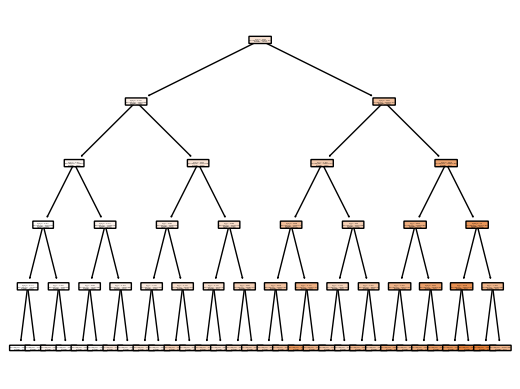

In [73]:
from utils import time_series_validation_tree

results, model_fit, model_predict = time_series_validation_tree(B, y, base_data=base_data1, model=pipe)

In [59]:
results.describe()

,fold,n_train,n_test,mae_train,mape_train,rmse_train,r2_train,mae_validation,mape_validation,rmse_validation,r2_validation
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,4.50000,217866.900000,33522.100000,340.942510,0.224924,489.204938,0.851903,287.299115,0.186374,431.001722,0.882206
std,3.02765,19735.146271,19735.146271,4.328835,0.004415,5.065233,0.004948,26.347195,0.004809,39.547169,0.012023
min,0.00000,188153.000000,4876.000000,334.187997,0.218410,482.439567,0.844370,256.032680,0.179350,384.021045,0.861927
25%,2.25000,203427.500000,18473.000000,337.695084,0.221280,484.589857,0.847578,265.987891,0.182081,400.017765,0.873696
50%,4.50000,217994.500000,33394.500000,341.441847,0.225716,489.166453,0.853746,285.969942,0.187935,423.560014,0.882721
75%,6.75000,232916.000000,47961.500000,344.666310,0.229106,493.476137,0.856106,303.313657,0.190374,459.739505,0.891378
max,9.00000,246513.000000,63236.000000,346.521806,0.229801,495.953445,0.856911,332.765119,0.191772,498.511992,0.898449


Inside Loadsmart, our best results have the following metrics:


|       | fold     | n_train       | n_test       | mae_train  | mape_train | rmse_train | r2_train  | mae_validation | mape_validation | rmse_validation | r2_validation |
|-------|----------|---------------|--------------|------------|------------|------------|-----------|----------------|-----------------|-----------------|---------------|
| count | 10.00000 | 10.000000     | 10.000000    | 10.000000  | 10.000000  | 10.000000  | 10.000000 | 10.000000      | 10.000000       | 10.000000       | 10.000000     |
| mean  | 4.50000  | 217866.900000 | 33522.100000 | 120.586458 | 0.080597   | 175.242199 | 0.981004  | 174.046851     | 0.106311        | 272.630327      | 0.952791      |
| std   | 3.02765  | 19735.146271  | 19735.146271 | 0.907818   | 0.000250   | 1.432716   | 0.000175  | 24.347798      | 0.009780        | 33.929964       | 0.007855      |
| min   | 0.00000  | 188153.000000 | 4876.000000  | 118.612774 | 0.080320   | 172.410812 | 0.980745  | 141.197421     | 0.089839        | 226.967634      | 0.943898      |
| 25%   | 2.25000  | 203427.500000 | 18473.000000 | 120.219746 | 0.080419   | 174.516023 | 0.980927  | 151.584169     | 0.098085        | 241.544542      | 0.945193      |
| 50%   | 4.50000  | 217994.500000 | 33394.500000 | 120.791637 | 0.080512   | 175.406539 | 0.980949  | 174.336434     | 0.109823        | 273.213741      | 0.951213      |
| 75%   | 6.75000  | 232916.000000 | 47961.500000 | 121.234121 | 0.080748   | 176.356280 | 0.981101  | 195.721658     | 0.114013        | 302.999041      | 0.960495      |
| max   | 9.00000  | 246513.000000 | 63236.000000 | 121.679890 | 0.081133   | 177.112705 | 0.981295  | 206.832642     | 0.118338        | 317.767363      | 0.963967      |

The results above contain clever feature engineering, modeling and hyper-parameter tuning. Our model of choice is the LightGBM, due it's low error in prediction and fast training time.

#### Copying above code with X vars **random forest**

In [74]:
B = pd.concat([X, base_data1], axis=1)

In [75]:
numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]

numerical_features = X.select_dtypes(include=numerics).columns.to_list()
categorical_features = X.select_dtypes(exclude=numerics).columns.to_list()
categorical_features

['equipment_type', 'origin_kma', 'dest_kma', 'rolling', 'team_driver']

In [78]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from utils import ConstantImputer #add utils.py by clicking folder on the left, and add file to "content" folder 

numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", ConstantImputer()),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

regressor = RandomForestRegressor(max_depth=5)

pipe = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", regressor)])

Executing fold 0


/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


AttributeError: ignored

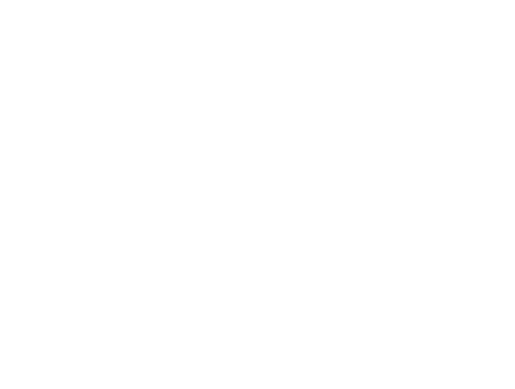

In [79]:
from utils import time_series_validation_tree

results = time_series_validation_tree(B, y, base_data=base_data1, model=pipe)

In [ ]:
results.describe()

,fold,n_train,n_test,mae_train,mape_train,rmse_train,r2_train,mae_validation,mape_validation,rmse_validation,r2_validation
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,4.50000,217866.900000,33522.100000,323.964112,0.216186,455.670034,0.871542,255.770661,0.169820,373.514939,0.911506
std,3.02765,19735.146271,19735.146271,3.114722,0.003744,2.499570,0.002673,24.557362,0.003522,38.791226,0.011277
min,0.00000,188153.000000,4876.000000,318.362362,0.210462,451.244582,0.867461,229.979179,0.164679,333.707648,0.886149
25%,2.25000,203427.500000,18473.000000,321.960933,0.213137,454.507710,0.869699,237.072393,0.167389,343.066535,0.909138
50%,4.50000,217994.500000,33394.500000,324.553051,0.216289,455.671520,0.872304,250.563316,0.169057,363.256592,0.913750
75%,6.75000,232916.000000,47961.500000,326.429611,0.219608,457.551716,0.873536,266.277265,0.172721,389.924175,0.919964
max,9.00000,246513.000000,63236.000000,327.483528,0.220633,459.382532,0.874817,305.280971,0.175243,452.678527,0.923315


,fold,n_train,n_test,mae_train,mape_train,rmse_train,r2_train,mae_validation,mape_validation,rmse_validation,r2_validation
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,4.50000,217866.900000,33522.100000,323.964112,0.216186,455.670034,0.871542,255.770661,0.169820,373.514939,0.911506
std,3.02765,19735.146271,19735.146271,3.114722,0.003744,2.499570,0.002673,24.557362,0.003522,38.791226,0.011277
min,0.00000,188153.000000,4876.000000,318.362362,0.210462,451.244582,0.867461,229.979179,0.164679,333.707648,0.886149
25%,2.25000,203427.500000,18473.000000,321.960933,0.213137,454.507710,0.869699,237.072393,0.167389,343.066535,0.909138
50%,4.50000,217994.500000,33394.500000,324.553051,0.216289,455.671520,0.872304,250.563316,0.169057,363.256592,0.913750
75%,6.75000,232916.000000,47961.500000,326.429611,0.219608,457.551716,0.873536,266.277265,0.172721,389.924175,0.919964
max,9.00000,246513.000000,63236.000000,327.483528,0.220633,459.382532,0.874817,305.280971,0.175243,452.678527,0.923315


Inside Loadsmart, our best results have the following metrics:


|       | fold     | n_train       | n_test       | mae_train  | mape_train | rmse_train | r2_train  | mae_validation | mape_validation | rmse_validation | r2_validation |
|-------|----------|---------------|--------------|------------|------------|------------|-----------|----------------|-----------------|-----------------|---------------|
| count | 10.00000 | 10.000000     | 10.000000    | 10.000000  | 10.000000  | 10.000000  | 10.000000 | 10.000000      | 10.000000       | 10.000000       | 10.000000     |
| mean  | 4.50000  | 217866.900000 | 33522.100000 | 120.586458 | 0.080597   | 175.242199 | 0.981004  | 174.046851     | 0.106311        | 272.630327      | 0.952791      |
| std   | 3.02765  | 19735.146271  | 19735.146271 | 0.907818   | 0.000250   | 1.432716   | 0.000175  | 24.347798      | 0.009780        | 33.929964       | 0.007855      |
| min   | 0.00000  | 188153.000000 | 4876.000000  | 118.612774 | 0.080320   | 172.410812 | 0.980745  | 141.197421     | 0.089839        | 226.967634      | 0.943898      |
| 25%   | 2.25000  | 203427.500000 | 18473.000000 | 120.219746 | 0.080419   | 174.516023 | 0.980927  | 151.584169     | 0.098085        | 241.544542      | 0.945193      |
| 50%   | 4.50000  | 217994.500000 | 33394.500000 | 120.791637 | 0.080512   | 175.406539 | 0.980949  | 174.336434     | 0.109823        | 273.213741      | 0.951213      |
| 75%   | 6.75000  | 232916.000000 | 47961.500000 | 121.234121 | 0.080748   | 176.356280 | 0.981101  | 195.721658     | 0.114013        | 302.999041      | 0.960495      |
| max   | 9.00000  | 246513.000000 | 63236.000000 | 121.679890 | 0.081133   | 177.112705 | 0.981295  | 206.832642     | 0.118338        | 317.767363      | 0.963967      |

The results above contain clever feature engineering, modeling and hyper-parameter tuning. Our model of choice is the LightGBM, due it's low error in prediction and fast training time.